In [16]:
import random
import string
import re
import sys
import nltk
import spacy
import torch

import pandas as pd
import numpy as np
import scipy.sparse as sps
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as opt
import torch.utils.data as dt

from sklearn.preprocessing import LabelBinarizer, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV

from spacy import displacy

from nlp_project.notebook_utils import evaluate, split, save_scikit_model, load_scikit_model
from nlp_project.nn_utils import init_gpu
from nlp_project.nn_classifier import Data, Classifier
from nlp_project.nn_extra import EarlyStopping, AdaptLR

In [2]:
seed = 69420
np.random.seed(seed)
random.seed(seed)

In [3]:
%%capture # noqa [REMOVE TO RUN NOTEBOOK]

# Saved Models path
models_path = "./models/T2_DepParsing"

# Classification labels
labels = ["A", "B", "C", "D", "E", "F"]

# Load spacy pipeline model
!{sys.executable} -m spacy download en_core_web_sm
#import en_core_web_sm
nlp_model = spacy.load("en_core_web_sm")

In [4]:
# Import main dataset
df = pd.read_csv("../../AUTEXTIFICATION/subtask_2/train.tsv", sep="\t")
df = df.drop("id", axis=1)

df

,text,label
0,It was not until many years later that it coul...,A
1,Users can then pin these images to their profi...,F
2,The best songs are those that I can sing along...,B
3,I found this book to be poorly written. It was...,D
4,Regulates the application of the EU tariff quo...,E
...,...,...
22411,The ministry had earlier said it was working w...,B
22412,"Once combined, slowly add the melted butter, s...",F
22413,Hightower for this new and wellwritten book!. ...,B
22414,All throughout the whole book this author has ...,D


In [5]:
def extract_features(tree):
    features = []
    for token in tree:
        lemma = token.lemma_
        pos_tag = token.pos_
        dep_lab = token.dep_
        head = token.head
        if token.i < head.i:
            direction = "l"
        else:
            direction = "r"
        dfr = len(list(token.ancestors))
        # if not token.is_stop:
        features.append({
            "lem": lemma ,
            "pos": pos_tag, 
            "dep": dep_lab, 
            "head": head, 
            "dir": direction, 
            "dfr": dfr
        })
    return features

In [6]:
# Run SpaCy NLP pipeline on dataset
parsed_df = df.copy()
parsed_df["text"] = df["text"].apply(lambda x: nlp_model(x))

In [7]:
# Extract useful features
parsed_df["features"] = parsed_df["text"].apply(lambda x: extract_features(x))
parsed_df

,text,label,features
0,"(It, was, not, until, many, years, later, that...",A,"[{'lem': 'it', 'pos': 'PRON', 'dep': 'nsubj', ..."
1,"(Users, can, then, pin, these, images, to, the...",F,"[{'lem': 'user', 'pos': 'NOUN', 'dep': 'nsubj'..."
2,"(The, best, songs, are, those, that, I, can, s...",B,"[{'lem': 'the', 'pos': 'DET', 'dep': 'det', 'h..."
3,"(I, found, this, book, to, be, poorly, written...",D,"[{'lem': 'I', 'pos': 'PRON', 'dep': 'nsubj', '..."
4,"(Regulates, the, application, of, the, EU, tar...",E,"[{'lem': 'regulate', 'pos': 'VERB', 'dep': 'RO..."
...,...,...,...
22411,"(The, ministry, had, earlier, said, it, was, w...",B,"[{'lem': 'the', 'pos': 'DET', 'dep': 'det', 'h..."
22412,"(Once, combined, ,, slowly, add, the, melted, ...",F,"[{'lem': 'once', 'pos': 'ADV', 'dep': 'advmod'..."
22413,"(Hightower, for, this, new, and, wellwritten, ...",B,"[{'lem': 'Hightower', 'pos': 'PROPN', 'dep': '..."
22414,"(All, throughout, the, whole, book, this, auth...",D,"[{'lem': 'all', 'pos': 'ADV', 'dep': 'advmod',..."


In [8]:
# Example structure
displacy.render(parsed_df["text"][0], jupyter=True, style='dep')

In [9]:
# vectorizer = CountVectorizer(stop_words="english")
# vectorizer = TfidfVectorizer(min_df=4, max_df=0.6, stop_words="english")
vectorizer = TfidfVectorizer(min_df=4, max_df=0.6)

parsed_df["text_lem"] = parsed_df["features"].apply(lambda x: " ".join([t["lem"] for t in x]))

In [10]:
x, y = parsed_df["text_lem"], parsed_df["label"]
x_train, x_val, x_test, y_train, y_val, y_test = split(
    x, y, test_size=0.2, val_size=0.0, seed=seed
)
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)

In [11]:
models = []
usecached = False

# Naive Bayes
nb = MultinomialNB()
nb_param = {"alpha":[0.001, 0.01, 0.1, 1, 10, 100]}
nb_clf = GridSearchCV(nb, nb_param, cv=5, scoring="f1_micro", verbose=1)
models.append({
    "name": "Naive Bayes",
    "model": nb_clf,
    "usecached": usecached,
})

# Logistic Regression
lr = LogisticRegression(max_iter=100000)
lr_param = [{
    "solver": ["liblinear"], 
    "penalty": ["l1", "l2"],
    "C":[0.01, 0.1, 1, 10]
},{
    "solver": ("lbfgs", "sag", "saga"), 
    "penalty": ["l2"],
    "C":[0.01, 0.1, 1]
}]
lr_clf = GridSearchCV(lr, lr_param, cv=5, scoring="f1_micro", verbose=1)
models.append({
    "name": "Linear Regression",
    "model": lr_clf,
    "subsample": 0.8,
    "usecached": usecached,
})

# SVC
svc = SVC()
svc_param = {"kernel": ["rbf"], "C": [0.1, 1, 10]}
svc_clf = GridSearchCV(svc, svc_param, cv=5, scoring="f1_micro", verbose=1)
models.append({
    "name": "SVC", 
    "model": svc_clf, 
    "subsample": 0.7,
    "usecached": usecached,
})

In [12]:
for model in models:
    if model["usecached"]:
        cache = load_scikit_model(models_path, model["name"])
        if cache:
            model["best"] = cache
            print(f"Restored model for {model['name']}")
            continue
        else:
            print(f"Couldn't restore model for {model['name']}")
            
    x_train_, y_train_ = x_train, y_train
    if "subsample" in model.keys():
        x_train_, _, y_train_, _ = train_test_split(
            x_train, 
            y_train, 
            test_size=model["subsample"], 
            stratify=y_train
        )
            
    print(f"Training {model['name']}")        
    model["model"].fit(x_train_, y_train_)
    
    print("Found best model")
    model["best"] = model["model"].best_estimator_
    model["best"].fit(x_train, y_train)
    print("Trained best model")
    
    save_scikit_model(models_path, model["best"], model["name"])

Training Naive Bayes
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model
Trained best model
Training Linear Regression
Fitting 5 folds for each of 17 candidates, totalling 85 fits
Found best model
Trained best model
Training SVC
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Found best model
Trained best model


Naive Bayes
Best parameters: {'alpha': 1}
Best CV score: 0.3312517579516165
              precision    recall  f1-score   support

           A       0.33      0.49      0.40       712
           B       0.26      0.33      0.29       730
           C       0.23      0.22      0.22       737
           D       0.33      0.27      0.30       774
           E       0.31      0.22      0.26       765
           F       0.60      0.48      0.53       766

    accuracy                           0.33      4484
   macro avg       0.34      0.34      0.33      4484
weighted avg       0.35      0.33      0.33      4484



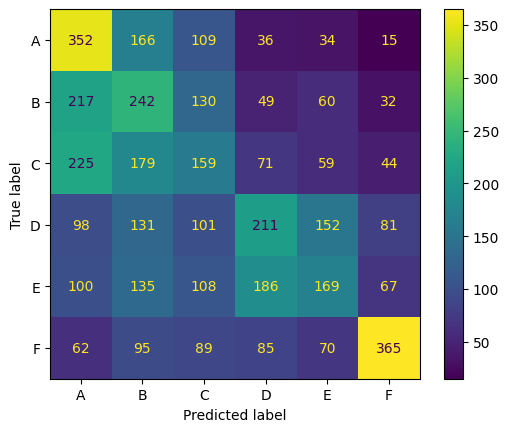

Linear Regression
Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV score: 0.36028989561116226
              precision    recall  f1-score   support

           A       0.50      0.58      0.54       712
           B       0.35      0.28      0.31       730
           C       0.37      0.29      0.32       737
           D       0.34      0.37      0.36       774
           E       0.32      0.31      0.32       765
           F       0.55      0.67      0.60       766

    accuracy                           0.42      4484
   macro avg       0.41      0.42      0.41      4484
weighted avg       0.41      0.42      0.41      4484



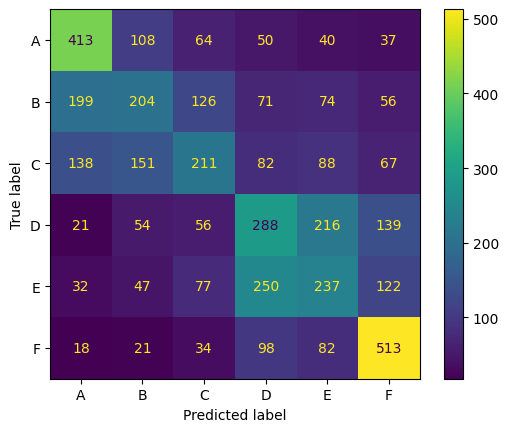

SVC
Best parameters: {'C': 10, 'kernel': 'rbf'}
Best CV score: 0.3658687645889167
              precision    recall  f1-score   support

           A       0.50      0.50      0.50       712
           B       0.35      0.32      0.34       730
           C       0.36      0.34      0.35       737
           D       0.35      0.38      0.36       774
           E       0.33      0.34      0.34       765
           F       0.61      0.62      0.61       766

    accuracy                           0.42      4484
   macro avg       0.42      0.42      0.42      4484
weighted avg       0.42      0.42      0.42      4484



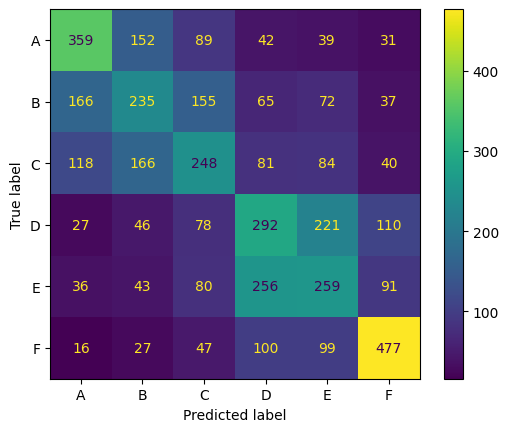

In [13]:
for model in models:
    print(f"{model['name']}")
    if hasattr(model["model"], "cv_results_"):
        print(f"Best parameters: {model['model'].best_params_}")
        print(f"Best CV score: {model['model'].best_score_}")
    y_pred = model['best'].predict(x_test)
    evaluate(y_test, y_pred, labels=labels)

In [17]:
x_lem = parsed_df["features"].apply(lambda x: " ".join([t["lem"] for t in x]))
x_pos = parsed_df["features"].apply(lambda x: " ".join([t["pos"] for t in x]))
x_avgdfr = parsed_df["features"].apply(lambda x: sum(t["dfr"] for t in x) / len(x))
y = parsed_df["label"]
x_train_lem, x_val_lem, x_test_lem, y_train, y_val, y_test = split(
    x_lem, y, test_size=0.2, val_size=0.0, seed=seed
)
x_train_pos, x_val_pos, x_test_pos, y_train, y_val, y_test = split(
    x_pos, y, test_size=0.2, val_size=0.0, seed=seed
)
x_train_avgdfr, x_val_avgdfr, x_test_avgdfr, y_train, y_val, y_test = split(
    x_avgdfr, y, test_size=0.2, val_size=0.0, seed=seed
)

In [18]:
# Vectorizing POS tags with a TfidfVectorizer gives much better results overall, however
# using a CountVectorizer has marginally better results for tree-based methods

# Vectorize lemmas
vectorizer = TfidfVectorizer(min_df=4, ngram_range=(2,2))
x_train_lem = vectorizer.fit_transform(x_train_lem)
x_test_lem = vectorizer.transform(x_test_lem)

# Vectorize POS tags
vectorizer = TfidfVectorizer(min_df=4)
x_train_pos = vectorizer.fit_transform(x_train_pos)
x_test_pos = vectorizer.transform(x_test_pos)

# Normalize average distance from root
mms = MinMaxScaler()

x_train_avgdfr = mms.fit_transform(x_train_avgdfr.values.reshape(-1, 1))
x_test_avgdfr = mms.transform(x_test_avgdfr.values.reshape(-1, 1))

x_train_avgdfr = sps.csr_matrix(x_train_avgdfr)
x_test_avgdfr = sps.csr_matrix(x_test_avgdfr)

# Concatenate vectors
x_train = sps.hstack([x_train_lem, x_train_pos, x_train_avgdfr])
x_test = sps.hstack([x_test_lem, x_test_pos, x_test_avgdfr])

In [19]:
models = []
usecached = False

# Naive Bayes
nb = MultinomialNB()
nb_param = {"alpha":[0.001, 0.01, 0.1, 1, 10, 100]}
nb_clf = GridSearchCV(nb, nb_param, cv=5, scoring="f1_micro", verbose=1)
models.append({
    "name": "Naive Bayes", 
    "model": nb_clf,
    "usecached": usecached,
})

# Logistic Regression
lr = LogisticRegression(max_iter=100000)
lr_param = [{
    "solver": ["liblinear"], 
    "penalty": ["l1", "l2"],
    "C":[0.01, 0.1, 1, 10]
},{
    "solver": ("lbfgs", "sag", "saga"), 
    "penalty": ["l2"],
    "C":[0.01, 0.1, 1]
}]
lr_clf = GridSearchCV(lr, lr_param, cv=5, scoring="f1_micro", verbose=1)
models.append({
    "name": "Linear Regression",
    "model": lr_clf,
    "subsample": 0.8,
    "usecached": usecached,
})

# SVC
svc = SVC()
svc_param = {"kernel": ["rbf"], "C": [0.1, 1, 10]}
svc_clf = GridSearchCV(svc, svc_param, cv=5, scoring="f1_micro", verbose=1)
models.append({
    "name": "SVC", 
    "model": svc_clf,
    "subsample": 0.7,
    "usecached": usecached,
})

# Decision Tree
dtree = DecisionTreeClassifier()
dtree_param = {
    "criterion": ["gini", "entropy"], 
    # "min_samples_split": [2, 4, 8],
    # "min_samples_leaf": [1, 2, 4],
    "max_features": [None, "sqrt", "log2"],
}
dtree_clf =  GridSearchCV(dtree, dtree_param, cv=5, scoring="f1_micro", verbose=1)
models.append({
    "name": "Decision Tree",
    "model": dtree_clf,
    "usecached": usecached,
})

# Random Forest
rf = RandomForestClassifier()
rf_param = {
    # "n_estimators": [50, 100, 200, 400],
    # "max_depth": [None, 5, 10],
    "criterion": ["gini", "entropy"],
    # "min_samples_split": [2, 4, 8],
    # "min_samples_leaf": [1, 2, 4],
    # "max_features": [None, "sqrt", "log2"],
    # "oob_score": [True, False]
}
rf_clf =  GridSearchCV(rf, rf_param, cv=5, scoring="f1_micro", verbose=1)
models.append({
    "name": "Random Forest",
    "model": rf_clf,
    "subsample": 0.6,
    "usecached": usecached,
})

# Extra Trees
et = ExtraTreesClassifier()
et_param = {
    # "n_estimators": [50, 100, 200, 400],
    # "max_depth": [None, 5, 10],
    "criterion": ["gini", "entropy"],
    # "min_samples_split": [2, 4, 8],
    # "min_samples_leaf": [1, 2, 4],
    # "max_features": [None, "sqrt", "log2"],
    # "oob_score": [True, False]
}
et_clf =  GridSearchCV(et, et_param, cv=5, scoring="f1_micro", verbose=1)
models.append({
    "name": "Extra Trees",
    "model": et_clf,
    "subsample": 0.6,
    "usecached": usecached,
})

In [20]:
for model in models:
    if model["usecached"]:
        cache = load_scikit_model(models_path, model["name"])
        if cache:
            model["best"] = cache
            print(f"Restored model for {model['name']}")
            continue
        else:
            print(f"Couldn't restore model for {model['name']}")
            
    x_train_, y_train_ = x_train, y_train
    if "subsample" in model.keys():
        x_train_, _, y_train_, _ = train_test_split(
            x_train, 
            y_train, 
            test_size=model["subsample"], 
            stratify=y_train
        )
            
    print(f"Training {model['name']}")        
    model["model"].fit(x_train_, y_train_)
    
    print("Found best model")
    model["best"] = model["model"].best_estimator_
    model["best"].fit(x_train, y_train)
    print("Trained best model")
    
    save_scikit_model(models_path, model["best"], model["name"])

Training Naive Bayes
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model
Trained best model
Training Linear Regression
Fitting 5 folds for each of 17 candidates, totalling 85 fits
Found best model
Trained best model
Training SVC
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Found best model
Trained best model
Training Decision Tree
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model
Trained best model
Training Random Forest
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Found best model
Trained best model
Training Extra Trees
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Found best model
Trained best model


Naive Bayes
Best parameters: {'alpha': 1}
Best CV score: 0.3708454073868719
              precision    recall  f1-score   support

           A       0.49      0.38      0.42       712
           B       0.29      0.28      0.28       730
           C       0.29      0.23      0.25       737
           D       0.30      0.42      0.35       774
           E       0.29      0.33      0.31       765
           F       0.62      0.59      0.60       766

    accuracy                           0.37      4484
   macro avg       0.38      0.37      0.37      4484
weighted avg       0.38      0.37      0.37      4484



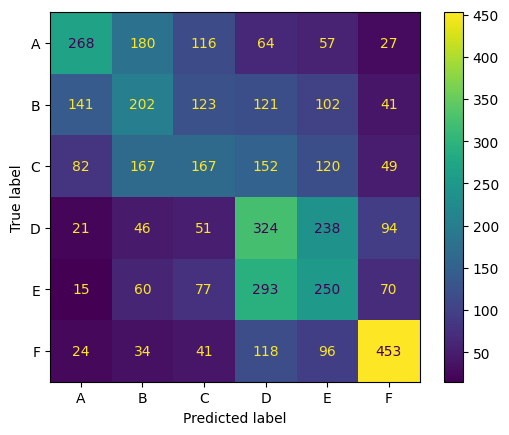

Linear Regression
Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV score: 0.3630785188983811
              precision    recall  f1-score   support

           A       0.47      0.48      0.47       712
           B       0.33      0.32      0.32       730
           C       0.31      0.28      0.29       737
           D       0.34      0.37      0.35       774
           E       0.31      0.32      0.31       765
           F       0.61      0.64      0.62       766

    accuracy                           0.40      4484
   macro avg       0.40      0.40      0.40      4484
weighted avg       0.40      0.40      0.40      4484



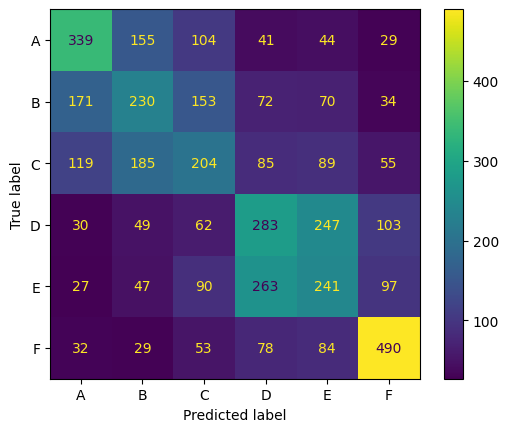

SVC
Best parameters: {'C': 10, 'kernel': 'rbf'}
Best CV score: 0.3809253911991009
              precision    recall  f1-score   support

           A       0.51      0.53      0.52       712
           B       0.36      0.36      0.36       730
           C       0.35      0.31      0.33       737
           D       0.36      0.39      0.38       774
           E       0.34      0.33      0.34       765
           F       0.64      0.62      0.63       766

    accuracy                           0.43      4484
   macro avg       0.43      0.43      0.43      4484
weighted avg       0.43      0.43      0.43      4484



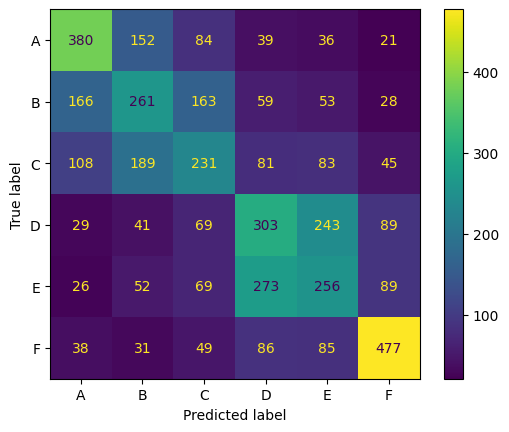

Decision Tree
Best parameters: {'criterion': 'gini', 'max_features': None}
Best CV score: 0.26516810798615753
              precision    recall  f1-score   support

           A       0.35      0.34      0.35       712
           B       0.21      0.22      0.22       730
           C       0.21      0.21      0.21       737
           D       0.28      0.27      0.27       774
           E       0.26      0.26      0.26       765
           F       0.36      0.35      0.35       766

    accuracy                           0.28      4484
   macro avg       0.28      0.28      0.28      4484
weighted avg       0.28      0.28      0.28      4484



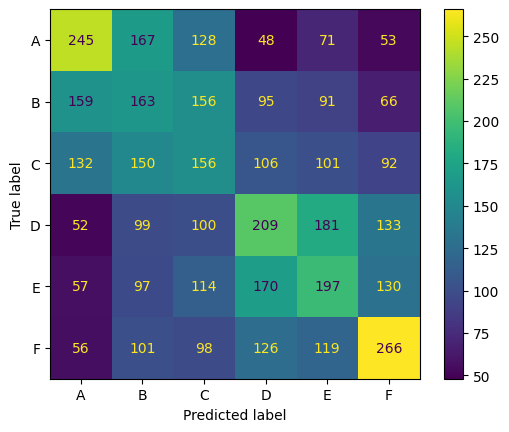

Random Forest
Best parameters: {'criterion': 'gini'}
Best CV score: 0.3685170012489126
              precision    recall  f1-score   support

           A       0.44      0.61      0.51       712
           B       0.32      0.21      0.25       730
           C       0.28      0.15      0.19       737
           D       0.33      0.42      0.37       774
           E       0.30      0.28      0.29       765
           F       0.50      0.62      0.55       766

    accuracy                           0.38      4484
   macro avg       0.36      0.38      0.36      4484
weighted avg       0.36      0.38      0.36      4484



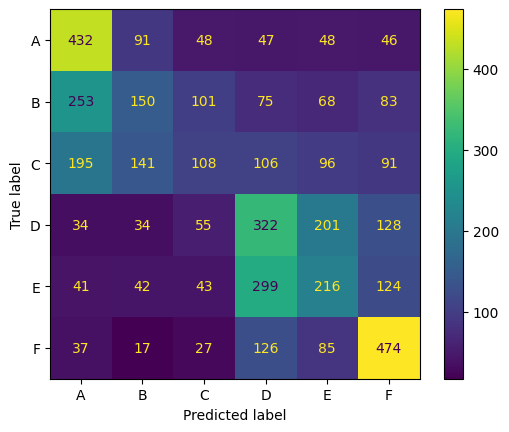

Extra Trees
Best parameters: {'criterion': 'gini'}
Best CV score: 0.36698088726254874
              precision    recall  f1-score   support

           A       0.44      0.60      0.51       712
           B       0.32      0.18      0.23       730
           C       0.33      0.17      0.22       737
           D       0.33      0.44      0.37       774
           E       0.29      0.29      0.29       765
           F       0.52      0.63      0.57       766

    accuracy                           0.38      4484
   macro avg       0.37      0.38      0.36      4484
weighted avg       0.37      0.38      0.36      4484



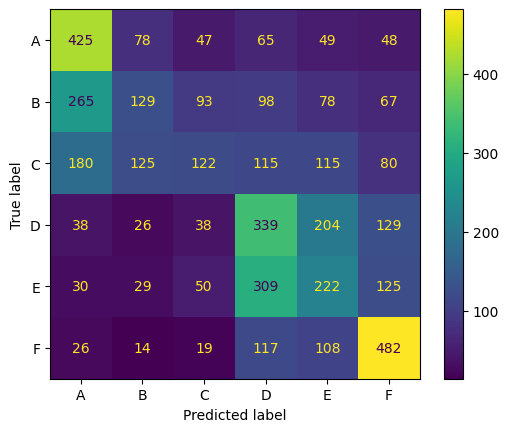

In [21]:
for model in models:
    print(f"{model['name']}")
    if hasattr(model["model"], "cv_results_"):
        print(f"Best parameters: {model['model'].best_params_}")
        print(f"Best CV score: {model['model'].best_score_}")
    y_pred = model['best'].predict(x_test)
    evaluate(y_test, y_pred, labels=labels)

In [22]:
epochs = 100
batch_size = 32

num_workers = 8 # Tune it based on your machine specs
device = init_gpu()

In [23]:
y_ = LabelEncoder().fit_transform(y).astype(float)
x_train_lem, x_val_lem, x_test_lem, y_train, y_val, y_test = split(
    x_lem, y_, test_size=0.1, val_size=0.1, seed=seed
)
x_train_pos, x_val_pos, x_test_pos, y_train, y_val, y_test = split(
    x_pos, y_, test_size=0.1, val_size=0.1, seed=seed
)
x_train_avgdfr, x_val_avgdfr, x_test_avgdfr, y_train, y_val, y_test = split(
    x_avgdfr, y_, test_size=0.1, val_size=0.1, seed=seed
)

In [24]:
# Vectorize lemmas
vectorizer = TfidfVectorizer(min_df=4, max_df=0.6)
x_train_lem = vectorizer.fit_transform(x_train_lem)
x_val_lem = vectorizer.transform(x_val_lem)
x_test_lem = vectorizer.transform(x_test_lem)

# Vectorize POS tags
vectorizer = TfidfVectorizer()
x_train_pos = vectorizer.fit_transform(x_train_pos)
x_val_pos = vectorizer.transform(x_val_pos)
x_test_pos = vectorizer.transform(x_test_pos)

# Normalize average distance from root
mms = MinMaxScaler()

x_train_avgdfr = mms.fit_transform(x_train_avgdfr.values.reshape(-1, 1))
x_val_avgdfr = mms.transform(x_val_avgdfr.values.reshape(-1, 1))
x_test_avgdfr = mms.transform(x_test_avgdfr.values.reshape(-1, 1))

x_train_avgdfr = sps.csr_matrix(x_train_avgdfr)
x_val_avgdfr = sps.csr_matrix(x_val_avgdfr)
x_test_avgdfr = sps.csr_matrix(x_test_avgdfr)

# Concatenate vectors
x_train = sps.hstack([x_train_lem, x_train_pos, x_train_avgdfr])
x_val = sps.hstack([x_val_lem, x_val_pos, x_val_avgdfr])
x_test = sps.hstack([x_test_lem, x_test_pos, x_test_avgdfr])

In [25]:
ds_train = Data(x_train, y_train, x_type=np.float32, y_type=torch.long)
ds_val = Data(x_val, y_val, x_type=np.float32, y_type=torch.long)
ds_test = Data(x_test, y_test, x_type=np.float32, y_type=torch.long)

train_dl = dt.DataLoader(
    ds_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    # pin_memory_device=device.type, # Doesn't work on CPU
)
val_dl = dt.DataLoader(ds_val,     
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    # pin_memory_device=device.type, # Doesn't work on CPU
)
test_dl = dt.DataLoader(ds_test, batch_size=batch_size, shuffle=False)

/home/riga/Documents/NLP/NLP_Project/nlp_project/nn_classifier.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  torch.LongTensor([x_coo.row, x_coo.col]),


In [26]:
in_dim = x_train.shape[1]
out_dim = 1 if len(labels) <= 2 else len(labels)

In [27]:
class Network(Classifier):
    def __init__(self, in_dim, out_dim, binary_classifier=False, device=torch.device("cpu"), verbose=True):
        super().__init__(binary_classifier, device, verbose)
        self.l1 = nn.Linear(in_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, out_dim)
        self.dp = nn.Dropout(p=0.5)
        
        self.relu = nn.ReLU()
        self.sm = nn.Softmax(dim=0)
        
    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.dp(x)
        x = self.sm(self.l3(x))
        return x

In [28]:
nn_model = Network(in_dim, out_dim, binary_classifier=False, device=device)
loss = nn.CrossEntropyLoss()
optimizer = opt.Adam(nn_model.parameters(), lr=0.01)
nn_model.compile(loss, optimizer)

In [29]:
earlystop = EarlyStopping(metric="val_acc", patience=10, baseline=0.3)
lradjust = AdaptLR(metric="val_acc", patience=5, factor=0.1)
callbacks = [earlystop, lradjust]

# nn_model.load_state_dict(torch.load(models_path + "NN Model"))
history = nn_model.train_loop(train_dl, epochs, data_val=val_dl, callbacks=callbacks)

Epoch 1 -- loss: 0.0549347 acc: 0.2956725 val_loss: 0.0556442 val_acc: 0.2979483
Epoch 2 -- loss: 0.0541753 acc: 0.3479813 val_loss: 0.0555042 val_acc: 0.3028546
Epoch 3 -- loss: 0.0538432 acc: 0.3742472 val_loss: 0.0557151 val_acc: 0.3202498
Epoch 4 -- loss: 0.0534521 acc: 0.3957729 val_loss: 0.0553649 val_acc: 0.3153434
Epoch 5 -- loss: 0.0531602 acc: 0.4059224 val_loss: 0.0551051 val_acc: 0.3073149
Epoch 6 -- loss: 0.0530137 acc: 0.4234887 val_loss: 0.0551296 val_acc: 0.3117752
Epoch 7 -- loss: 0.0529822 acc: 0.4270578 val_loss: 0.0552843 val_acc: 0.3229260
Epoch 8 -- loss: 0.0528043 acc: 0.4340843 val_loss: 0.0551313 val_acc: 0.3256021
Epoch 9 -- loss: 0.0528116 acc: 0.4483605 val_loss: 0.0551819 val_acc: 0.3287244
Epoch 10 -- loss: 0.0527003 acc: 0.4539929 val_loss: 0.0552917 val_acc: 0.3242640
Epoch 11 -- loss: 0.0526945 acc: 0.4505354 val_loss: 0.0554353 val_acc: 0.3193577
Epoch 12 -- loss: 0.0526618 acc: 0.4495316 val_loss: 0.0552868 val_acc: 0.3064228
Epoch 13 -- loss: 0.05263

{'acc': tensor(0.3243), 'loss': 0.055480263841460584}
              precision    recall  f1-score   support

         0.0       0.57      0.29      0.38       356
         1.0       0.26      0.32      0.29       365
         2.0       0.25      0.34      0.29       368
         3.0       0.34      0.31      0.32       387
         4.0       0.26      0.33      0.29       383
         5.0       0.51      0.36      0.42       383

    accuracy                           0.32      2242
   macro avg       0.36      0.32      0.33      2242
weighted avg       0.36      0.32      0.33      2242



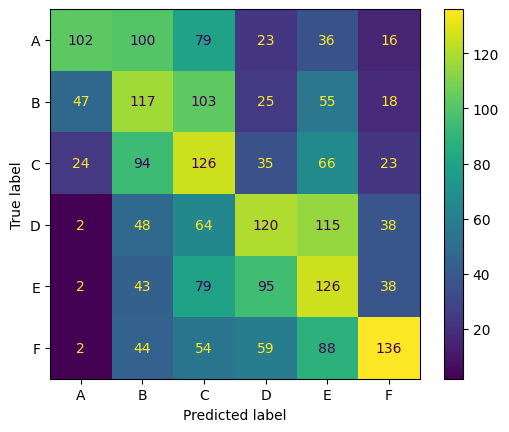

In [30]:
y_pred, metrics = nn_model.test_loop(test_dl)
print(metrics)
evaluate(y_test, y_pred, labels=labels)

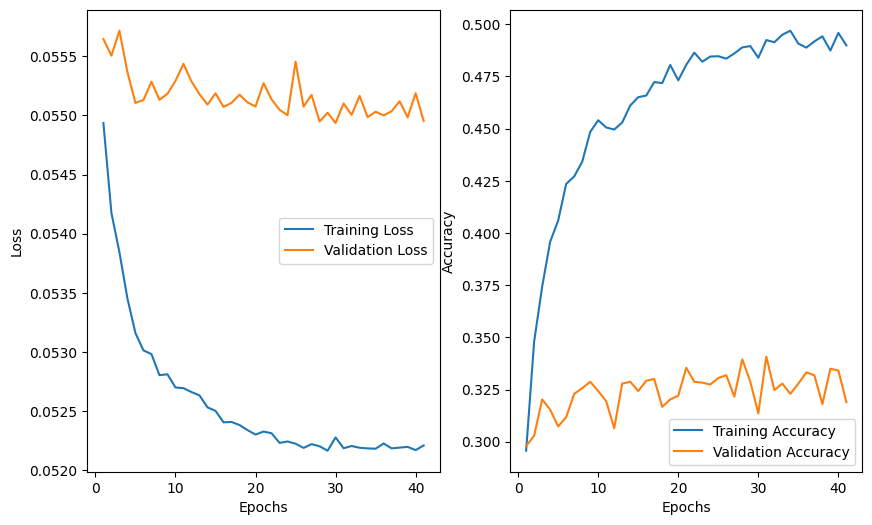

In [31]:
history = nn_model.history
plt_epochs = [h["epoch"] for h in history]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

tl = ax1.plot(plt_epochs, [h["loss"] for h in history], label="Training Loss")
vl = ax1.plot(plt_epochs, [h["val_loss"] for h in history], label="Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ta = ax2.plot(plt_epochs, [h["acc"] for h in history], label="Training Accuracy")
va = ax2.plot(plt_epochs, [h["val_acc"] for h in history], label="Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.show()

In [32]:
torch.save(nn_model.state_dict(), models_path + "/" + "NN Model")